# Read alto

In [1]:
from typing import Dict, List, Tuple
from collections import namedtuple, defaultdict
import lxml.etree as et
import os

class NoSourceImage(Exception):
    """ Raised when the ALTO is missing a link to an image file """

BBOX = namedtuple("Bbox", ["x1", "y1", "x2", "y2", "file", "id", "image"])
NS = {"a": "http://www.loc.gov/standards/alto/ns-v2#"}

def temporary_replace_path(xml_path):
    return f"../IMG/{xml_path.replace('.xml', '.jpg')}"

def read_alto(alto_xml) -> Tuple[Dict[str, List[BBOX]], str]:
    classes = defaultdict(list)
    
    with open(alto_xml) as f:
        xml = et.parse(f)
        source_image = xml.xpath("//a:sourceImageInformation/a:fileName/text()", namespaces=NS)
        if not len(source_image):
            raise NoSourceImage(f"{alto_xml} is missing the following node"
                                "`/alto/Description/sourceImageInformation/fileName`"
                               "which should contain the path to the image it is about")
        source_image = temporary_replace_path(source_image[0])
        source_image_real_path = os.path.abspath(
            os.path.join(os.path.dirname(alto_xml), source_image)
        )
        if not os.path.isfile(source_image_real_path):
            raise NoSourceImage(f"{alto_xml} has a wrong path at"
                                "`/alto/Description/sourceImageInformation/fileName`"
                               f": {source_image_real_path}")
        
        styles = {
            style.attrib["ID"]: style.attrib["FONTSTYLE"] if style.attrib["FONTSTYLE"] else "_"
            for style in xml.xpath("//a:TextStyle", namespaces=NS)
        }
        for string in xml.xpath("//a:String", namespaces=NS):
            x, y, = string.attrib["HPOS"], string.attrib["VPOS"]
            w, h = string.attrib["WIDTH"], string.attrib["HEIGHT"]
            x, y, w, h = float(x), float(y), float(w), float(h)
            style = styles[string.attrib["STYLEREFS"]]
            classes[style].append(BBOX(x, y, x+w, y+h, alto_xml, 
                                       string.attrib["ID"], source_image_real_path))
            
    return classes, source_image_real_path

import glob

data = defaultdict(list)
images = {}
for xml_path in glob.glob("./input/*/ALTO/*.xml"):
    current, image = read_alto(xml_path)
    images[image] = current
    for key in current:
        data[key].extend(current[key])
    
minimum = float("inf")
for cls in data:
    total = sum([len(val) for val in data.values()])
    print(f"{cls.zfill(10).replace('0', ' ')} : {len(data[cls])/total:.2f} of the whole ({len(data[cls])})")
    minimum = min([len(data[cls]), minimum])
print(minimum)

         _ : 0.91 of the whole (38663)
   italics : 0.04 of the whole (1731)
      bold : 0.05 of the whole (1928)
1731


# Extract images

In [2]:
import os
from IPython.display import display
import PIL.Image as PILImage
#import tqdm.tqdm

output_dir = "./data/"
os.makedirs(output_dir, exist_ok=True)


for image, bboxes in images.items():
    for cls, items in bboxes.items():
        source = PILImage.open(image)
        os.makedirs(os.path.join(output_dir, cls), exist_ok=True)
        for id_, bbox in enumerate(items):
            area = source.crop(bbox[:4])
            area.save(
                os.path.join(
                    output_dir,
                    cls,
                    f"{os.path.basename(bbox.image)}.{id_}.png"
                )
            ) 

# Split and generate test dataset

In [3]:
import random
test_dir = "./test_data"
os.makedirs(test_dir, exist_ok=True)

for cls in glob.glob("./data/*"):
    files = glob.glob(os.path.join(cls, "*.png"))
    random.shuffle(files)
    os.makedirs(cls.replace("data", "test_data"), exist_ok=True)
    for file in files[:int(minimum*0.1)]:
        os.rename(file, file.replace("data", "test_data"))
        
train_dir = "./train_data"
os.makedirs(train_dir, exist_ok=True)

for cls in glob.glob("./data/*"):
    files = glob.glob(os.path.join(cls, "*.png"))
    random.shuffle(files)
    os.makedirs(cls.replace("data", train_dir), exist_ok=True)
    for file in files[:minimum]:
        os.rename(file, file.replace("data", train_dir))

# Create dataset

In [27]:
import torchvision
import torchvision.transforms as transforms
import torch.utils.data

pre_process = transforms.Compose(
    [
        transforms.Grayscale(num_output_channels=1),
        #transforms.Resize((28, 28)),
        transforms.CenterCrop((28, 28)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.5], std=[0.5])
    ]
)

trainset = torchvision.datasets.ImageFolder(
    train_dir,
    transform=pre_process
)
testset = torchvision.datasets.ImageFolder(
    test_dir,
    transform=pre_process
)

trainloader = torch.utils.data.DataLoader(
    trainset, batch_size=4,
    shuffle=True, num_workers=2
)
testloader = torch.utils.data.DataLoader(
    testset, batch_size=4,
    shuffle=True, num_workers=2
)
classes = {n: key for n, key in enumerate(trainset.classes)}
test_classes = {n: key for n, key in enumerate(testset.classes)}
print(classes)
print(test_classes)
assert classes == test_classes

{0: '_', 1: 'bold', 2: 'italics'}
{0: '_', 1: 'bold', 2: 'italics'}


# Visualize sample

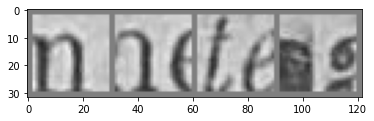

Classes    _     _ italics  bold


In [28]:
import matplotlib.pyplot as plt
import numpy as np

# functions to show an image


def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
dataiter = iter(trainloader)
images, labels = dataiter.next()

# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print("Classes" + ' '.join('%5s' % classes[labels[j].tolist()] for j in range(4)))

# Count classes in test set

In [29]:
# get some random training images
from collections import Counter

dataiter = iter(testloader)

out = []
for images, labels in dataiter:
    out.extend([classes[labels[j].tolist()] for j in range(len(labels))])
    
print(Counter(out))

Counter({'italics': 173, '_': 173, 'bold': 173})


In [30]:
import torch.nn as nn
import torch.nn.functional as F

class Net(nn.Module):
    def __init__(self, classes: int):
        super(Net, self).__init__()
        self.conv1 = nn.Conv2d(1, 10, kernel_size=5)
        self.conv1_drop = nn.Dropout2d()
        self.conv2 = nn.Conv2d(10, 20, kernel_size=5)
        self.conv2_drop = nn.Dropout2d()
        self.fc1 = nn.Linear(320, 50)
        self.fc2 = nn.Linear(50, classes)

    def forward(self, x):
        x = F.relu(F.max_pool2d(self.conv1_drop(self.conv1(x)), 2))
        x = F.relu(F.max_pool2d(self.conv2_drop(self.conv2(x)), 2))
        x = x.view(-1, 320)
        x = F.relu(self.fc1(x))
        x = F.dropout(x, training=self.training)
        x = self.fc2(x)
        return F.log_softmax(x)

In [43]:
# https://nextjournal.com/gkoehler/pytorch-mnist
import torch.optim as optim

n_epochs = 100
batch_size_train = 64
batch_size_test = 1000
learning_rate = 0.001
momentum = 0.5
log_interval = 100

random_seed = 1

network = Net(len(classes))
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)
lr_scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, verbose=True)


In [44]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(trainloader.dataset) for i in range(n_epochs + 1)]

In [47]:
def train(epoch):
    network.train()
    for batch_idx, (data, target) in enumerate(trainloader):
        optimizer.zero_grad()
        output = network(data)
        loss = F.nll_loss(output, target)
        loss.backward()
        optimizer.step()
        
        if batch_idx % log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(trainloader.dataset),
                100. * batch_idx / len(trainloader), loss.item()))
            train_losses.append(loss.item())
            train_counter.append(
                (batch_idx*64) + ((epoch-1)*len(trainloader.dataset)))
            torch.save(network.state_dict(), './results/model.pth')
            torch.save(optimizer.state_dict(), './results/optimizer.pth')
    lr_scheduler.step(loss)

In [41]:
def test():
  network.eval()
  test_loss = 0
  correct = 0
  with torch.no_grad():
    for data, target in testloader:
      output = network(data)
      test_loss += F.nll_loss(output, target, size_average=False).item()
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(testloader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(testloader.dataset),
    100. * correct / len(testloader.dataset)))

In [48]:
test()
for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()

/home/thibault/dev/alto-fontstyle-classifier/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 1.1029, Accuracy: 173/519 (33%)

Train Epoch: 1 [0/5020 (0%)]	Loss: 1.119196
Train Epoch: 1 [400/5020 (8%)]	Loss: 1.111358
Train Epoch: 1 [800/5020 (16%)]	Loss: 1.104193
Train Epoch: 1 [1200/5020 (24%)]	Loss: 1.131489
Train Epoch: 1 [1600/5020 (32%)]	Loss: 1.099206
Train Epoch: 1 [2000/5020 (40%)]	Loss: 1.063928
Train Epoch: 1 [2400/5020 (48%)]	Loss: 1.135306
Train Epoch: 1 [2800/5020 (56%)]	Loss: 1.080824
Train Epoch: 1 [3200/5020 (64%)]	Loss: 1.056047
Train Epoch: 1 [3600/5020 (72%)]	Loss: 1.132410
Train Epoch: 1 [4000/5020 (80%)]	Loss: 1.093631
Train Epoch: 1 [4400/5020 (88%)]	Loss: 1.094402
Train Epoch: 1 [4800/5020 (96%)]	Loss: 1.106431

Test set: Avg. loss: 1.0948, Accuracy: 232/519 (45%)

Train Epoch: 2 [0/5020 (0%)]	Loss: 1.094679
Train Epoch: 2 [400/5020 (8%)]	Loss: 1.077314
Train Epoch: 2 [800/5020 (16%)]	Loss: 1.084013
Train Epoch: 2 [1200/5020 (24%)]	Loss: 1.100687
Train Epoch: 2 [1600/5020 (32%)]	Loss: 1.103486
Train Epoch: 2 [2000/5020 (40%)]	Loss: 1

Train Epoch: 13 [400/5020 (8%)]	Loss: 0.874925
Train Epoch: 13 [800/5020 (16%)]	Loss: 0.594800
Train Epoch: 13 [1200/5020 (24%)]	Loss: 0.927224
Train Epoch: 13 [1600/5020 (32%)]	Loss: 0.711652
Train Epoch: 13 [2000/5020 (40%)]	Loss: 0.486497
Train Epoch: 13 [2400/5020 (48%)]	Loss: 0.383975
Train Epoch: 13 [2800/5020 (56%)]	Loss: 0.616082
Train Epoch: 13 [3200/5020 (64%)]	Loss: 1.141925
Train Epoch: 13 [3600/5020 (72%)]	Loss: 0.618363
Train Epoch: 13 [4000/5020 (80%)]	Loss: 0.659854
Train Epoch: 13 [4400/5020 (88%)]	Loss: 1.323017
Train Epoch: 13 [4800/5020 (96%)]	Loss: 0.759155

Test set: Avg. loss: 0.6320, Accuracy: 356/519 (69%)

Train Epoch: 14 [0/5020 (0%)]	Loss: 1.033715
Train Epoch: 14 [400/5020 (8%)]	Loss: 0.596660
Train Epoch: 14 [800/5020 (16%)]	Loss: 0.345134
Train Epoch: 14 [1200/5020 (24%)]	Loss: 0.198671
Train Epoch: 14 [1600/5020 (32%)]	Loss: 0.579176
Train Epoch: 14 [2000/5020 (40%)]	Loss: 0.662268
Train Epoch: 14 [2400/5020 (48%)]	Loss: 0.772731
Train Epoch: 14 [2800/50

Train Epoch: 25 [400/5020 (8%)]	Loss: 0.861475
Train Epoch: 25 [800/5020 (16%)]	Loss: 0.580936
Train Epoch: 25 [1200/5020 (24%)]	Loss: 0.715002
Train Epoch: 25 [1600/5020 (32%)]	Loss: 0.970273
Train Epoch: 25 [2000/5020 (40%)]	Loss: 0.498904
Train Epoch: 25 [2400/5020 (48%)]	Loss: 0.826379
Train Epoch: 25 [2800/5020 (56%)]	Loss: 0.778156
Train Epoch: 25 [3200/5020 (64%)]	Loss: 0.615328
Train Epoch: 25 [3600/5020 (72%)]	Loss: 0.162532
Train Epoch: 25 [4000/5020 (80%)]	Loss: 0.548541
Train Epoch: 25 [4400/5020 (88%)]	Loss: 0.244947
Train Epoch: 25 [4800/5020 (96%)]	Loss: 1.333489

Test set: Avg. loss: 0.5253, Accuracy: 414/519 (80%)

Train Epoch: 26 [0/5020 (0%)]	Loss: 0.599109
Train Epoch: 26 [400/5020 (8%)]	Loss: 0.442289
Train Epoch: 26 [800/5020 (16%)]	Loss: 0.306682
Train Epoch: 26 [1200/5020 (24%)]	Loss: 0.116286
Train Epoch: 26 [1600/5020 (32%)]	Loss: 0.795581
Train Epoch: 26 [2000/5020 (40%)]	Loss: 0.665921
Train Epoch: 26 [2400/5020 (48%)]	Loss: 1.172656
Train Epoch: 26 [2800/50

Train Epoch: 37 [400/5020 (8%)]	Loss: 0.765176
Train Epoch: 37 [800/5020 (16%)]	Loss: 0.843082
Train Epoch: 37 [1200/5020 (24%)]	Loss: 0.400372
Train Epoch: 37 [1600/5020 (32%)]	Loss: 0.480521
Train Epoch: 37 [2000/5020 (40%)]	Loss: 7.383526
Train Epoch: 37 [2400/5020 (48%)]	Loss: 0.313620
Train Epoch: 37 [2800/5020 (56%)]	Loss: 0.257117
Train Epoch: 37 [3200/5020 (64%)]	Loss: 0.606934
Train Epoch: 37 [3600/5020 (72%)]	Loss: 0.409820
Train Epoch: 37 [4000/5020 (80%)]	Loss: 0.608504
Train Epoch: 37 [4400/5020 (88%)]	Loss: 0.337492
Train Epoch: 37 [4800/5020 (96%)]	Loss: 0.766120

Test set: Avg. loss: 0.5047, Accuracy: 420/519 (81%)

Train Epoch: 38 [0/5020 (0%)]	Loss: 0.667535
Train Epoch: 38 [400/5020 (8%)]	Loss: 0.707156
Train Epoch: 38 [800/5020 (16%)]	Loss: 0.661562
Train Epoch: 38 [1200/5020 (24%)]	Loss: 0.297282
Train Epoch: 38 [1600/5020 (32%)]	Loss: 0.410457
Train Epoch: 38 [2000/5020 (40%)]	Loss: 1.102776
Train Epoch: 38 [2400/5020 (48%)]	Loss: 0.239747
Train Epoch: 38 [2800/50

Train Epoch: 49 [0/5020 (0%)]	Loss: 0.576121
Train Epoch: 49 [400/5020 (8%)]	Loss: 0.468227
Train Epoch: 49 [800/5020 (16%)]	Loss: 0.533679
Train Epoch: 49 [1200/5020 (24%)]	Loss: 0.756001
Train Epoch: 49 [1600/5020 (32%)]	Loss: 0.248438
Train Epoch: 49 [2000/5020 (40%)]	Loss: 0.681468
Train Epoch: 49 [2400/5020 (48%)]	Loss: 0.317794
Train Epoch: 49 [2800/5020 (56%)]	Loss: 0.423397
Train Epoch: 49 [3200/5020 (64%)]	Loss: 0.826671
Train Epoch: 49 [3600/5020 (72%)]	Loss: 0.656341
Train Epoch: 49 [4000/5020 (80%)]	Loss: 0.311322
Train Epoch: 49 [4400/5020 (88%)]	Loss: 0.445820
Train Epoch: 49 [4800/5020 (96%)]	Loss: 0.491109

Test set: Avg. loss: 0.4757, Accuracy: 423/519 (82%)

Train Epoch: 50 [0/5020 (0%)]	Loss: 0.240638
Train Epoch: 50 [400/5020 (8%)]	Loss: 0.620545
Train Epoch: 50 [800/5020 (16%)]	Loss: 0.282577
Train Epoch: 50 [1200/5020 (24%)]	Loss: 1.366042
Train Epoch: 50 [1600/5020 (32%)]	Loss: 1.613927
Train Epoch: 50 [2000/5020 (40%)]	Loss: 0.657407
Train Epoch: 50 [2400/5020 (


Test set: Avg. loss: 0.4735, Accuracy: 426/519 (82%)

Train Epoch: 61 [0/5020 (0%)]	Loss: 0.768580
Train Epoch: 61 [400/5020 (8%)]	Loss: 0.661820
Train Epoch: 61 [800/5020 (16%)]	Loss: 0.669182
Train Epoch: 61 [1200/5020 (24%)]	Loss: 0.761540
Train Epoch: 61 [1600/5020 (32%)]	Loss: 0.719195
Train Epoch: 61 [2000/5020 (40%)]	Loss: 0.544030
Train Epoch: 61 [2400/5020 (48%)]	Loss: 0.891243
Train Epoch: 61 [2800/5020 (56%)]	Loss: 0.225240
Train Epoch: 61 [3200/5020 (64%)]	Loss: 0.917625
Train Epoch: 61 [3600/5020 (72%)]	Loss: 0.424674
Train Epoch: 61 [4000/5020 (80%)]	Loss: 1.356202
Train Epoch: 61 [4400/5020 (88%)]	Loss: 0.582774
Train Epoch: 61 [4800/5020 (96%)]	Loss: 0.440579

Test set: Avg. loss: 0.4741, Accuracy: 425/519 (82%)

Train Epoch: 62 [0/5020 (0%)]	Loss: 0.236109
Train Epoch: 62 [400/5020 (8%)]	Loss: 0.464458
Train Epoch: 62 [800/5020 (16%)]	Loss: 0.279439
Train Epoch: 62 [1200/5020 (24%)]	Loss: 0.215346
Train Epoch: 62 [1600/5020 (32%)]	Loss: 0.258599
Train Epoch: 62 [2000/

Train Epoch: 72 [4800/5020 (96%)]	Loss: 0.530374

Test set: Avg. loss: 0.4744, Accuracy: 424/519 (82%)

Train Epoch: 73 [0/5020 (0%)]	Loss: 0.262284
Train Epoch: 73 [400/5020 (8%)]	Loss: 0.586823
Train Epoch: 73 [800/5020 (16%)]	Loss: 1.130450
Train Epoch: 73 [1200/5020 (24%)]	Loss: 0.539847
Train Epoch: 73 [1600/5020 (32%)]	Loss: 0.575984
Train Epoch: 73 [2000/5020 (40%)]	Loss: 0.907579
Train Epoch: 73 [2400/5020 (48%)]	Loss: 0.631077
Train Epoch: 73 [2800/5020 (56%)]	Loss: 0.630522
Train Epoch: 73 [3200/5020 (64%)]	Loss: 0.461156
Train Epoch: 73 [3600/5020 (72%)]	Loss: 1.723468
Train Epoch: 73 [4000/5020 (80%)]	Loss: 0.344304
Train Epoch: 73 [4400/5020 (88%)]	Loss: 0.092959
Train Epoch: 73 [4800/5020 (96%)]	Loss: 0.888513

Test set: Avg. loss: 0.4743, Accuracy: 425/519 (82%)

Train Epoch: 74 [0/5020 (0%)]	Loss: 0.293400
Train Epoch: 74 [400/5020 (8%)]	Loss: 1.183713
Train Epoch: 74 [800/5020 (16%)]	Loss: 0.748905
Train Epoch: 74 [1200/5020 (24%)]	Loss: 0.645527
Train Epoch: 74 [1600/

Train Epoch: 84 [4400/5020 (88%)]	Loss: 0.507346
Train Epoch: 84 [4800/5020 (96%)]	Loss: 0.056324

Test set: Avg. loss: 0.4743, Accuracy: 425/519 (82%)

Train Epoch: 85 [0/5020 (0%)]	Loss: 0.315054
Train Epoch: 85 [400/5020 (8%)]	Loss: 0.843788
Train Epoch: 85 [800/5020 (16%)]	Loss: 0.138077
Train Epoch: 85 [1200/5020 (24%)]	Loss: 0.630585
Train Epoch: 85 [1600/5020 (32%)]	Loss: 1.623685
Train Epoch: 85 [2000/5020 (40%)]	Loss: 0.781478
Train Epoch: 85 [2400/5020 (48%)]	Loss: 0.544907
Train Epoch: 85 [2800/5020 (56%)]	Loss: 1.055612
Train Epoch: 85 [3200/5020 (64%)]	Loss: 0.656052
Train Epoch: 85 [3600/5020 (72%)]	Loss: 0.429478
Train Epoch: 85 [4000/5020 (80%)]	Loss: 0.594119
Train Epoch: 85 [4400/5020 (88%)]	Loss: 0.604450
Train Epoch: 85 [4800/5020 (96%)]	Loss: 0.381408

Test set: Avg. loss: 0.4743, Accuracy: 425/519 (82%)

Train Epoch: 86 [0/5020 (0%)]	Loss: 0.356893
Train Epoch: 86 [400/5020 (8%)]	Loss: 0.015682
Train Epoch: 86 [800/5020 (16%)]	Loss: 0.408465
Train Epoch: 86 [1200/

Train Epoch: 96 [4000/5020 (80%)]	Loss: 0.386474
Train Epoch: 96 [4400/5020 (88%)]	Loss: 0.334049
Train Epoch: 96 [4800/5020 (96%)]	Loss: 0.149398

Test set: Avg. loss: 0.4744, Accuracy: 425/519 (82%)

Train Epoch: 97 [0/5020 (0%)]	Loss: 0.114452
Train Epoch: 97 [400/5020 (8%)]	Loss: 0.652653
Train Epoch: 97 [800/5020 (16%)]	Loss: 0.464677
Train Epoch: 97 [1200/5020 (24%)]	Loss: 0.171317
Train Epoch: 97 [1600/5020 (32%)]	Loss: 0.662031
Train Epoch: 97 [2000/5020 (40%)]	Loss: 0.498985
Train Epoch: 97 [2400/5020 (48%)]	Loss: 0.070601
Train Epoch: 97 [2800/5020 (56%)]	Loss: 0.654311
Train Epoch: 97 [3200/5020 (64%)]	Loss: 0.927282
Train Epoch: 97 [3600/5020 (72%)]	Loss: 1.357441
Train Epoch: 97 [4000/5020 (80%)]	Loss: 0.123838
Train Epoch: 97 [4400/5020 (88%)]	Loss: 0.831735
Train Epoch: 97 [4800/5020 (96%)]	Loss: 0.419057

Test set: Avg. loss: 0.4744, Accuracy: 425/519 (82%)

Train Epoch: 98 [0/5020 (0%)]	Loss: 0.159417
Train Epoch: 98 [400/5020 (8%)]	Loss: 0.918545
Train Epoch: 98 [800/

In [49]:
def test():
    network.eval()
    test_loss = 0
    correct = 0
    targets, preds = [], []
    with torch.no_grad():
        for data, target in testloader:
            output = network(data)
            test_loss += F.nll_loss(output, target, size_average=False).item()
            pred = output.data.max(1, keepdim=True)[1]
            correct += pred.eq(target.data.view_as(pred)).sum()
            targets.extend(target.tolist())
            preds.extend(pred.tolist())
      
    test_loss /= len(testloader.dataset)
    test_losses.append(test_loss)
    print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
          test_loss, correct, len(testloader.dataset),
          100. * correct / len(testloader.dataset)))
    return targets, [int(x[0]) for x in preds]
gts, preds = test()
from sklearn.metrics import classification_report
print(classes)
print(classification_report(y_true=gts, y_pred=preds, target_names=[classes[i] for i in range(len(classes))]))

/home/thibault/dev/alto-fontstyle-classifier/env/lib/python3.7/site-packages/ipykernel_launcher.py:21: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



Test set: Avg. loss: 0.4744, Accuracy: 425/519 (82%)

{0: '_', 1: 'bold', 2: 'italics'}
              precision    recall  f1-score   support

           _       0.68      0.88      0.77       173
        bold       0.96      0.88      0.92       173
     italics       0.88      0.69      0.77       173

    accuracy                           0.82       519
   macro avg       0.84      0.82      0.82       519
weighted avg       0.84      0.82      0.82       519

